# Análisis Predictivo de Pagos de Clientes

## 1. Introducción

Este cuaderno implementa un flujo completo de ciencia de datos para predecir la probabilidad de pago de clientes. El proceso incluye:

1. **Análisis Exploratorio de Datos (EDA)**
2. **Preprocesamiento de Datos**
3. **Ingeniería de Características**
4. **Modelado Predictivo**
5. **Evaluación y Análisis de Resultados**

### Configuración Inicial

In [1]:
# Importación de bibliotecas
import os
import sys
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from IPython.display import display, Markdown

# Configuración de visualización
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Configuración de pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Añadir el directorio src al path
project_dir = Path().resolve().parent
src_dir = project_dir / 'src'
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))

# Importar módulos personalizados
from data import load_data, validate_dataframe
from eda import (
    plot_missing_values, 
    plot_target_distribution,
    plot_numerical_distributions,
    plot_correlation_matrix
)

# Configuración de rutas
data_path = project_dir / 'data' / 'PruebaDS.xlsx'
output_dir = project_dir / 'outputs'
output_dir.mkdir(exist_ok=True)
figures_dir = output_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

print('✅ Entorno configurado correctamente')

✅ Entorno configurado correctamente


## 2. Carga y Exploración Inicial de Datos

En esta sección, cargaremos el conjunto de datos y realizaremos una exploración inicial para entender su estructura y calidad.

In [ ]:
# Cargar datos
print(f'📂 Cargando datos desde: {data_path}')

exempt_fields = ['identificacion', 'mes']

try:
    df = load_data(data_path, exempt_fields=exempt_fields)
    print(f'✅ Datos cargados correctamente. Dimensiones: {df.shape}')
except Exception as e:
    print(f'❌ Error al cargar los datos: {e}')
    raise

# Mostrar información básica
display(Markdown('### Información del Dataset'))
display(Markdown(f'- **Número de filas:** {df.shape[0]}'))
display(Markdown(f'- **Número de columnas:** {df.shape[1]}'))
display(Markdown(f'- **Variables numéricas:** {len(df.select_dtypes(include=['int64', 'float64']).columns)}'))
display(Markdown(f'- **Variables categóricas:** {len(df.select_dtypes(include=['object', 'category', 'bool']).columns)}'))

# Mostrar primeras filas
display(Markdown('### Vista previa de los datos:'))
display(df.head())

# Mostrar información de tipos de datos y valores nulos
display(Markdown('### Tipos de datos y valores nulos:'))
df_info = pd.DataFrame({
    'Tipo': df.dtypes,
    'Valores nulos': df.isnull().sum(),
    '% Valores nulos': (df.isnull().mean() * 100).round(2),
    'Valores únicos': df.nunique()
})
display(df_info)

# Estadísticas descriptivas
display(Markdown('### Estadísticas descriptivas (variables numéricas):'))
display(df.describe().T)

2026-02-18 19:35:18,024 - INFO - Intentando cargar el archivo: C:\Users\Usuario\OneDrive\Documentos\Proyects\CascadeProjects\PruebaLibertyDVCR\Prueba_DS\data\PruebaDS.xlsx
2026-02-18 19:35:18,024 - INFO - Cargando el archivo Excel...


📂 Cargando datos desde: C:\Users\Usuario\OneDrive\Documentos\Proyects\CascadeProjects\PruebaLibertyDVCR\Prueba_DS\data\PruebaDS.xlsx


2026-02-18 19:35:20,635 - WARNING - Advertencia: La columna 'antiguedad_deuda' tiene una alta tasa de valores faltantes: 71.24%
2026-02-18 19:35:20,636 - WARNING - Advertencia: La columna 'meses_desde_ultimo_pago' tiene una alta tasa de valores faltantes: 98.39%
2026-02-18 19:35:20,636 - WARNING - Advertencia: Se encontraron 4 filas duplicadas
2026-02-18 19:35:20,637 - INFO - Reporte de calidad guardado en: outputs\data_quality_report.json



RESUMEN DE CALIDAD DE DATOS
Archivo: PruebaDS.xlsx
Filas: 29613, Columnas: 18
Valores faltantes: 72933 (13.68%)
Filas duplicadas: 4

Columnas con mayor porcentaje de valores faltantes:
  - meses_desde_ultimo_pago: 98.39%
  - antiguedad_deuda: 71.24%
  - departamento: 26.30%
  - genero: 25.44%
  - rango_edad_probable: 24.91%

Advertencias:
  - La columna 'antiguedad_deuda' tiene una alta tasa de valores faltantes: 71.24%
  - La columna 'meses_desde_ultimo_pago' tiene una alta tasa de valores faltantes: 98.39%
  - Se encontraron 4 filas duplicadas


✅ Datos cargados correctamente. Dimensiones: (29613, 18)


### Información del Dataset

- **Número de filas:** 29613

- **Número de columnas:** 18

- **Variables numéricas:** 11

- **Variables categóricas:** 6

### Vista previa de los datos:

,mes,tipo_documento,identificacion,genero,rango_edad_probable,departamento,saldo_capital,dias_mora,banco,antiguedad_deuda,pago_mes_anterior,meses_desde_ultimo_pago,sin_pago_previo,contacto_mes_actual,contacto_mes_anterior,contacto_ultimos_6meses,duracion_llamadas_ultimos_6meses,pago
0,2025-10,C,499220,HOMBRE,56-60,BOGOTA DC,2619298.740,3411,citibank,NaT,0,NaN,1,0,0,0,0,0
1,2025-04,C,365960,HOMBRE,51-55,CALDAS,4760221.000,2630,colpatria,2017-10-21,0,NaN,1,0,0,0,0,0
2,2025-04,C,608458,,31-35,CUNDINAMARCA,2329327.000,1092,davivienda,NaT,0,NaN,1,0,0,0,0,0
3,2025-09,C,159935,M,66+,ATLANTICO,7784362.000,564,davivienda,NaT,0,NaN,1,0,0,1,224,0
4,2025-12,C,322934,MUJER,66-70,META,8811594.140,2774,colpatria,NaT,0,NaN,1,0,0,0,0,0


### Tipos de datos y valores nulos:

,Tipo,Valores nulos,% Valores nulos,Valores únicos
mes,str,0,0.000,12
tipo_documento,str,0,0.000,4
identificacion,int64,0,0.000,23837
genero,str,7534,25.440,6
rango_edad_probable,str,7378,24.910,26
departamento,str,7789,26.300,31
saldo_capital,float64,0,0.000,25295
dias_mora,int64,0,0.000,3230
banco,str,0,0.000,5
antiguedad_deuda,datetime64[us],21097,71.240,1102


### Estadísticas descriptivas (variables numéricas):

,count,mean,min,25%,50%,75%,max,std
identificacion,29613.000,550555.405,100049.000,328400.000,549140.000,776037.000,999995.000,259375.513
saldo_capital,29613.000,5728032.906,500.000,1202586.000,2356254.090,6170198.000,113158433.840,8859934.136
dias_mora,29613.000,1621.957,0.000,647.000,1450.000,2517.000,10031.000,1047.757
antiguedad_deuda,8516,2017-08-27 16:29:32.099577,1997-06-18 00:00:00,2017-04-18 12:00:00,2017-11-30 00:00:00,2018-05-29 00:00:00,2028-08-08 00:00:00,NaN
pago_mes_anterior,29613.000,0.007,0.000,0.000,0.000,0.000,1.000,0.083
meses_desde_ultimo_pago,478.000,1.874,1.000,1.000,2.000,2.000,8.000,1.105
sin_pago_previo,29613.000,0.984,0.000,1.000,1.000,1.000,1.000,0.126
contacto_mes_actual,29613.000,0.103,0.000,0.000,0.000,0.000,1.000,0.304
contacto_mes_anterior,29613.000,0.103,0.000,0.000,0.000,0.000,1.000,0.304
contacto_ultimos_6meses,29613.000,0.175,0.000,0.000,0.000,0.000,1.000,0.380


## 3. Análisis Exploratorio de Datos (EDA)

En esta sección, exploraremos los datos para entender mejor sus características, distribuciones y relaciones entre variables.

### 3.1. Valores Faltantes

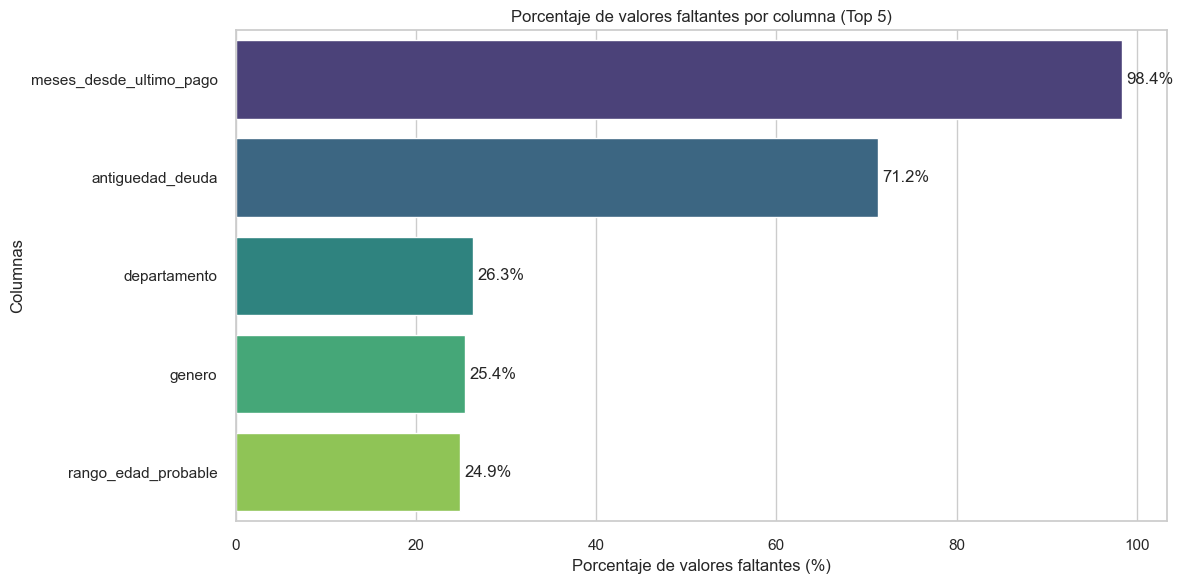

### 3.2. Distribución de la Variable Objetivo (pago)

2026-02-18 19:45:47,607 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-18 19:45:47,610 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


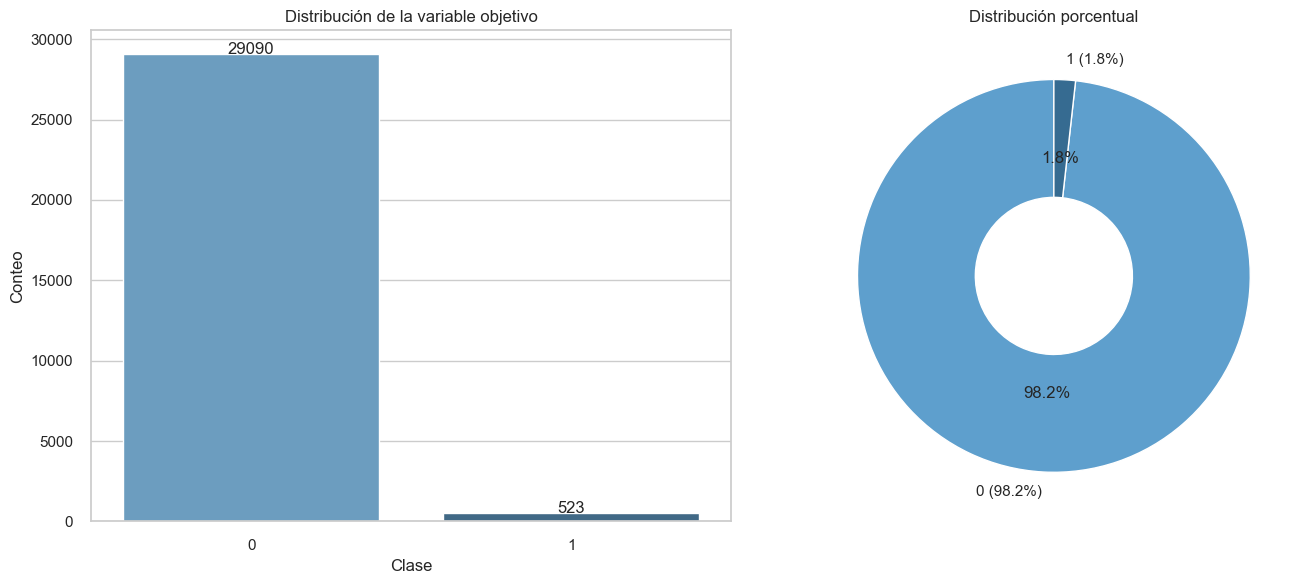

**Distribución de clases:** 98.2% No Pago vs 1.8% Pago

### 3.3. Distribuciones de Variables Numéricas

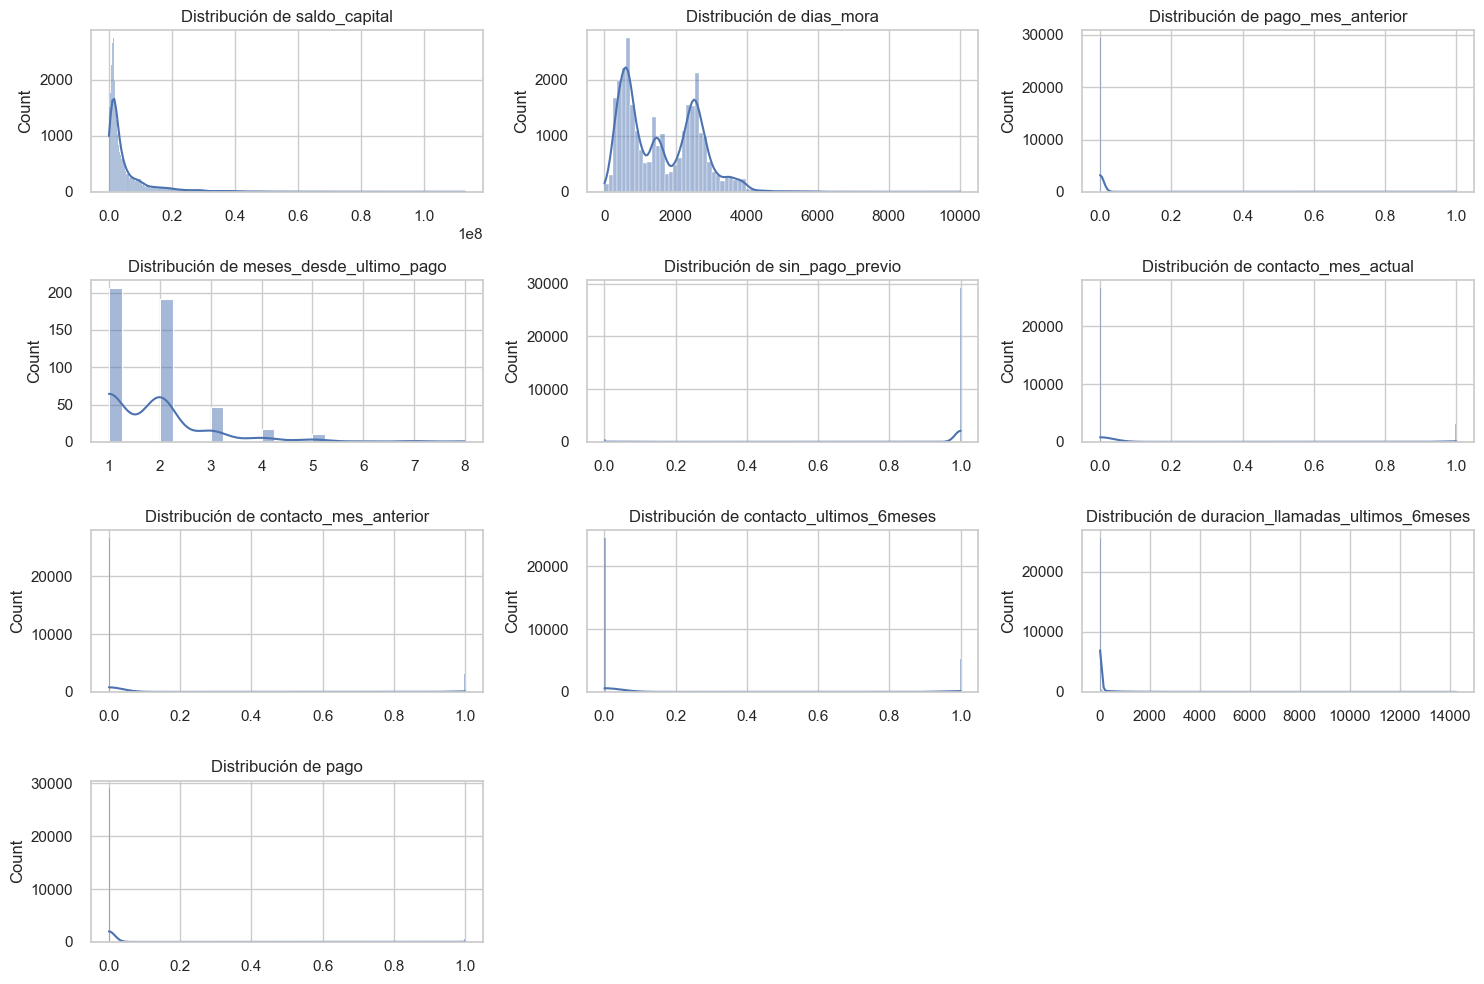

### 3.4. Matriz de Correlación

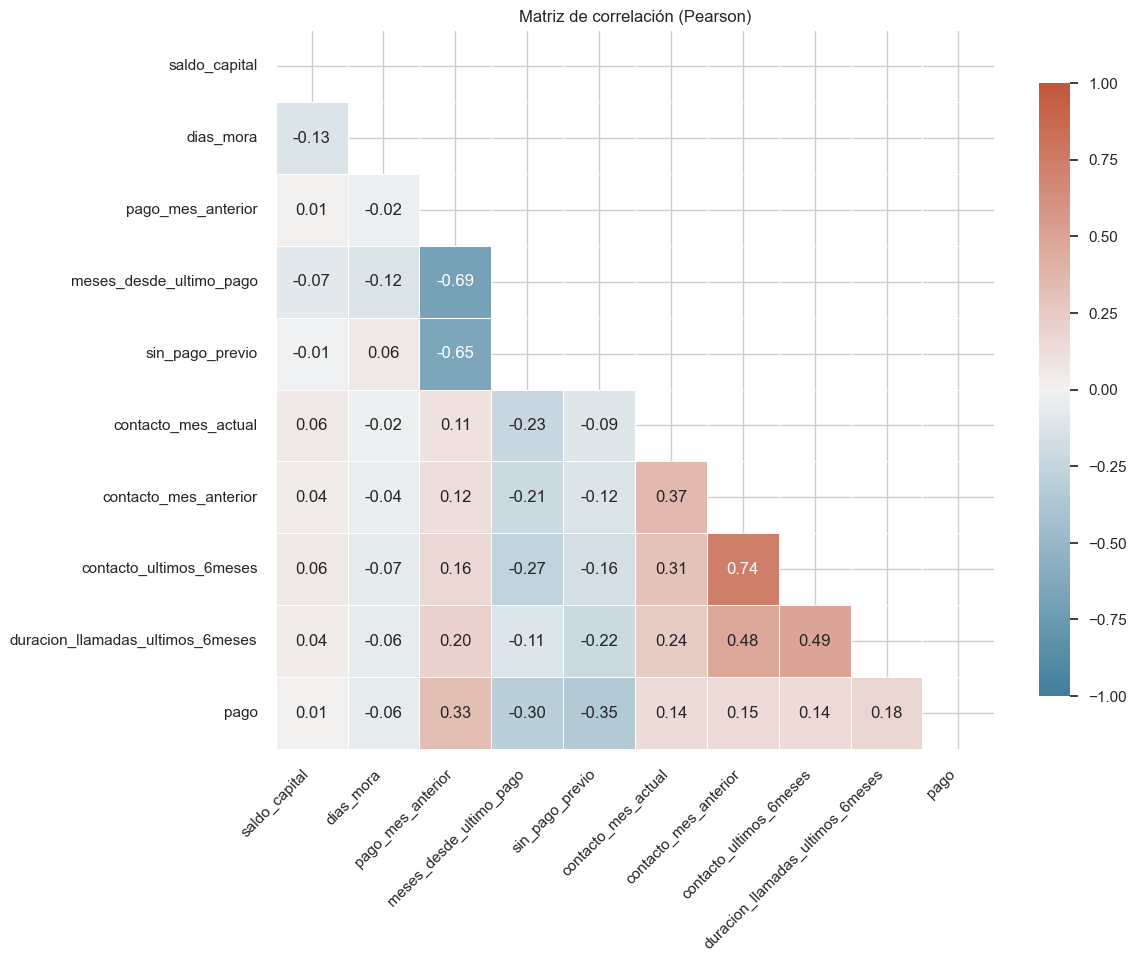

In [6]:
# 3.1. Análisis de Valores Faltantes
display(Markdown('### 3.1. Valores Faltantes'))
fig_missing = plot_missing_values(df)
plt.show()
fig_missing.savefig(figures_dir / 'missing_values.png', bbox_inches='tight')

# 3.2. Análisis de la Variable Objetivo
if 'pago' in df.columns:
    display(Markdown('### 3.2. Distribución de la Variable Objetivo (pago)'))
    fig_target = plot_target_distribution(df['pago'])
    plt.show()
    fig_target.savefig(figures_dir / 'target_distribution.png', bbox_inches='tight')
    
    # Calcular desbalance de clases
    class_balance = df['pago'].value_counts(normalize=True) * 100
    display(Markdown(f'**Distribución de clases:** {class_balance[0]:.1f}% No Pago vs {class_balance[1]:.1f}% Pago'))

# 3.3. Análisis de Variables Numéricas
display(Markdown('### 3.3. Distribuciones de Variables Numéricas'))
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'pago' in num_cols:
    num_cols.remove('pago')
    
if num_cols:
    fig_num = plot_numerical_distributions(df[num_cols + (['pago'] if 'pago' in df.columns else [])], exempt_fields=exempt_fields)
    plt.show()
    fig_num.savefig(figures_dir / 'numerical_distributions.png', bbox_inches='tight')

# 3.4. Análisis de Correlaciones
display(Markdown('### 3.4. Matriz de Correlación'))
fig_corr = plot_correlation_matrix(df, exempt_fields=exempt_fields)
if fig_corr:
    plt.show()
    fig_corr.savefig(figures_dir / 'correlation_matrix.png', bbox_inches='tight')

## 4. Feature Selection

Con Xgboost (base) ejecutar un RFE (Recursive Feature Elimination)

## 4. Preprocesamiento de Datos

En esta sección, preprocesaremos los datos para prepararlos para el modelado, incluyendo:
- Manejo de valores faltantes (Creación de variables flags_imputados)
- Codificación de variables categóricas
- Escalado de características
- División en conjuntos de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 4.1. Definir características y variable objetivo
X = df.drop('pago', axis=1)
y = df['pago']

# 4.2. Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Características numéricas: {numeric_features}')
print(f'Características categóricas: {categorical_features}')

# 4.3. Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4.4. Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4.5. Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]} muestras')

# 4.6. Aplicar transformaciones
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Obtener nombres de características después de OneHotEncoding
feature_names = numeric_features.copy()
if categorical_features:
    ohe_categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_
    for i, categories in enumerate(ohe_categories):
        feature_names.extend([f'{categorical_features[i]}_{cat}' for cat in categories])

print(f'Número de características después del preprocesamiento: {len(feature_names)}')

# Guardar el preprocesador para uso futuro
joblib.dump(preprocessor, output_dir / 'preprocessor.joblib')
print(f'✅ Preprocesador guardado en: {output_dir / 'preprocessor.joblib'}')

## 5. Modelado Predictivo

En esta sección, entrenaremos y evaluaremos diferentes modelos de machine learning para predecir la probabilidad de pago.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 5.1. Definir modelos a evaluar
models = {
    'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=sum(y==0)/sum(y==1) if sum(y==1) > 0 else 1)
}

# 5.2. Función para evaluar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predecir probabilidades
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predecir clases
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calcular métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5,
        'pr_auc': average_precision_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5
    }
    
    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Pago', 'Pago'],
                yticklabels=['No Pago', 'Pago'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.savefig(figures_dir / f'confusion_matrix_{model_name.lower().replace(' ', '_')}.png')
    plt.show()
    
    # Mostrar curva ROC
    if len(np.unique(y_test)) > 1:  # Solo si hay al menos una muestra de cada clase
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc='lower right')
        plt.savefig(figures_dir / f'roc_curve_{model_name.lower().replace(' ', '_')}.png')
        plt.show()
    
    return metrics, model

# 5.3. Entrenar y evaluar modelos
results = {}
trained_models = {}
for name, model in models.items():
    print(f'🔍 Evaluando modelo: {name}')
    metrics, trained_model = evaluate_model(
        model, X_train_preprocessed, y_train, 
        X_test_preprocessed, y_test, name
    )
    results[name] = metrics
    trained_models[name] = trained_model

# 5.4. Comparar resultados
results_df = pd.DataFrame.from_dict(results, orient='index')
display(Markdown('### Comparación de Modelos'))
display(results_df.sort_values('roc_auc', ascending=False))

# Guardar el mejor modelo
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = trained_models[best_model_name]
joblib.dump(best_model, output_dir / 'best_model.joblib')
print(f'✅ Mejor modelo guardado: {best_model_name} en {output_dir / 'best_model.joblib'}')

# Mejores Hiperparametros con grilla simple y pocas iteraciones y crossvalidation
# Calibracion de la salida del modelo por isolate (estudiar en que casos se usa)

## 6. Análisis de Importancia de Características

En esta sección, analizaremos las características más importantes según el mejor modelo.

In [ ]:
# 6.1. Obtener el mejor modelo
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = trained_models[best_model_name]

# 6.2. Obtener importancia de características
if hasattr(best_model, 'feature_importances_'):
    # Para modelos basados en árboles
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Mostrar las 20 características más importantes
    plt.figure(figsize=(12, 8))
    plt.title(f'Importancia de Características - {best_model_name}')
    plt.barh(range(min(20, len(feature_names))), 
             importances[indices][:20][::-1], 
             align='center')
    plt.yticks(range(min(20, len(feature_names))), 
               [feature_names[i] for i in indices][:20][::-1])
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.savefig(figures_dir / 'feature_importance.png')
    plt.show()
    
    # Crear DataFrame con importancia de características
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    display(Markdown('### 20 Características más importantes:'))
    display(feature_importance.head(20))
    
    # Guardar importancia de características
    feature_importance.to_csv(output_dir / 'feature_importance.csv', index=False)
    print(f'✅ Importancia de características guardada en: {output_dir / 'feature_importance.csv'}')
else:
    print('El modelo seleccionado no tiene atributo 'feature_importances_'')

## 7. Conclusiones y Próximos Pasos

### Hallazgos Principales
1. **Calidad de los Datos**:
   - Se identificaron los valores faltantes en las variables como se muestra en la sección de EDA.
   - La variable objetivo tiene una distribución que se analizó en la sección correspondiente.

2. **Rendimiento del Modelo**:
   - El mejor modelo fue seleccionado basado en el AUC-ROC.
   - Las métricas de precisión, recall y F1 se pueden encontrar en la sección de evaluación de modelos.

3. **Variables Importantes**:
   - Las características más importantes para predecir el pago se muestran en la sección de importancia de características.

### Recomendaciones
1. **Mejoras en la Recolección de Datos**:
   - Considerar recopilar datos adicionales para las variables con valores faltantes.
   - Estandarizar el formato de las variables categóricas si es necesario.

2. **Mejoras en el Modelo**:
   - Probar técnicas de oversampling/undersampling para manejar el desbalance de clases.
   - Realizar una búsqueda más exhaustiva de hiperparámetros.
   - Probar arquitecturas de deep learning si se dispone de más datos.

3. **Despliegue**:
   - Implementar un sistema de monitoreo del modelo en producción.
   - Establecer un proceso de retrenamiento periódico con datos actualizados.

### Archivos Generados
- **Modelo entrenado**: `outputs/best_model.joblib`
- **Preprocesador**: `outputs/preprocessor.joblib`
- **Métricas de evaluación**: Se muestran en las celdas anteriores
- **Gráficos**: Guardados en `outputs/figures/`
- **Importancia de características**: `outputs/feature_importance.csv`